# Домашнее задание №3. Линейная регрессия: переобучение и регуляризация

В этом задании вы выполните простую предобработку и визуализацию данных, построите на них линейную модель и проанализируете ее. В ходе выполнения задания вы также подробнее познакомитесь с регуляризацией и кросс-валидацией. В этом задании вы не будете сами реализовывать алгоритмы, вместо этого вы потратите больше времени на анализ результатов. 

Во всех ячейках, где написан комментарий с инструкциями или ###your code here, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Все задачи нужно выполнять исключительно самостоятельно! Если что-то непонятно, задавайте вопросы в чате. При обнаружении списывания ноль за задание ставится и тому, кто списал, и тому, у кого списали. Брать код из открытых источников можно тоже не более, чем одной строкой. И особенно аккуратно с обсуждением решений: обсуждать содержательные части - ок, но скидывать друг другу код не нужно.

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

Считайте данные и выведите первые 5 строк:

In [2]:
fn = "https://github.com/nadiinchi/iad2019/raw/master/materials/bikes_rent.csv"
df = pd.read_csv(fn)

In [7]:
df[:5]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12 (соответственно январь---декабрь)
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6 (соответственно понедельник---воскресенье)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. Давайте посмотрим на графиках, как целевой признак зависит от остальных

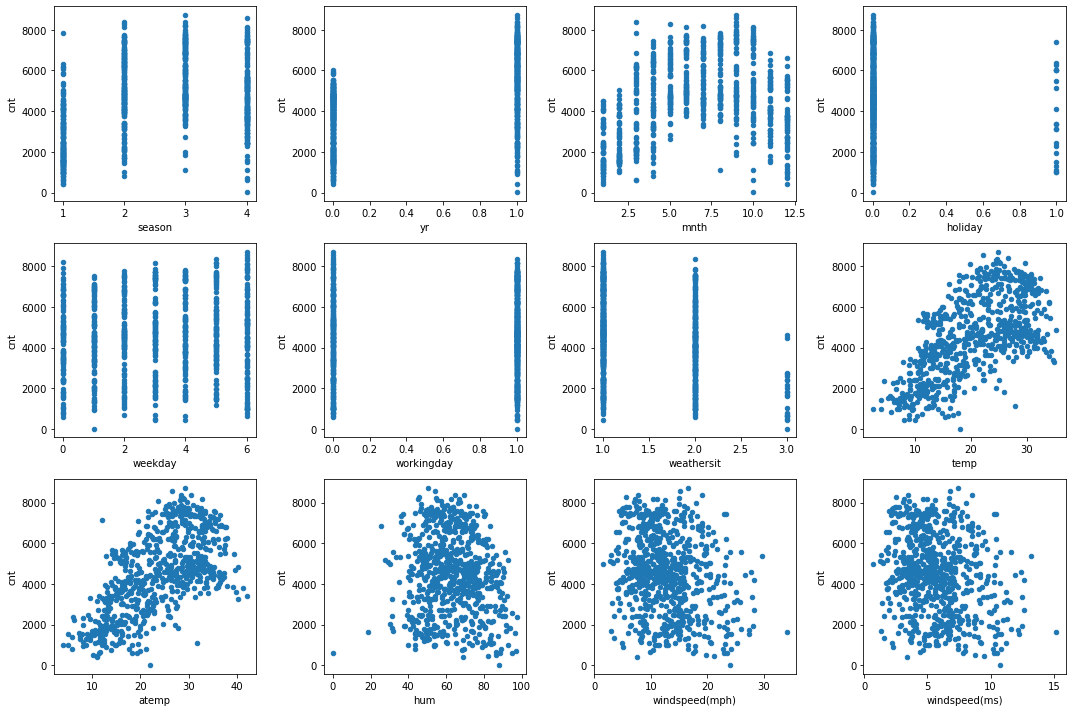

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
plt.tight_layout()

__Блок 1. Ответьте на вопросы (каждый 0.25 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * **ответ**: _чем ближе к лету, тем больше арендуют велосипедов, т.е. максимумы приходятся на **май-сентябрь**; зависимость нелинейная_
1. В какие дни: рабочие или выходные, людям чаще нужен велосипед?
   * **ответ**: _кажется, в рабочие, но корреляция слабая_
1. Укажите одну переменную, которая не влияет на cnt.
   * **ответ**: _если бы не предыдущий вопрос, я бы написала про workingday, но так - день недели (weekday)_
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * **ответ**: _temp (~atemp)_

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

##### Код 1.1 (0.5 балла)
Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

In [31]:
df.iloc[:, :-1].corrwith(df['cnt'], axis = 0)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, это говорит в пользу использования линейных методов.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

##### Код 1.2 (0.5 балла)
##### Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt с помощью метода corr:

In [34]:
df.loc[:, ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли единиц у бинарных признаков.

##### Код 1.3 (0.5 балла)
##### Выведите средние признаков

In [39]:
df.loc[:, ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].mean()

temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Попробуем обучить самую простую линейную регрессию
А именно, построим зависимость cnt от atemp

In [40]:
from sklearn.linear_model import LinearRegression

##### Код 1.4 (1 балл)
Создайте объект линейного регрессора, обучите его на ***X = df["atemp"] и y = df["cnt"]*** <br>
Затем сделайте предсказание на ***X_test = linspace*** (переменная, объявленная ниже) и запишите в переменную ***y_test***:

In [41]:
linspace = np.linspace(0, 40, 1000)[:, np.newaxis]

In [53]:
X = df["atemp"].to_numpy().reshape(-1, 1)
y = df["cnt"].to_numpy().reshape(-1, 1)

In [55]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [57]:
y_test = lr.predict(linspace)

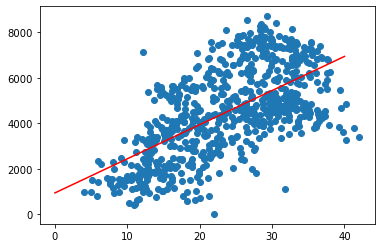

In [58]:
plt.scatter(df["atemp"], df["cnt"])
plt.plot(linspace.ravel(), y_test, c='r')

У вас должна получиться прямая, проходящая через изображенные точки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на дисперсию. Это можно сделать с помощью метода scale:

In [59]:
from sklearn.preprocessing import scale

In [60]:
X = scale(df[df.columns[:-1]])
y = df["cnt"]

Давайте обучим линейную регрессию на полных данных и посмотрим на веса признаков.

##### Код 2.1 (1 балл)
Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной coef_ класса регрессора).
Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python Названия признаков хранятся в переменной df.columns

In [62]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [65]:
for i, j in zip(df.columns, lr.coef_):
    print(i, j)

season 570.8673486059976
yr 1021.9688115339543
mnth -141.3037578631115
holiday -86.7575872078304
weekday 137.22531413389777
workingday 56.39226798994237
weathersit -330.22932400207895
temp 367.4716271455421
atemp 585.5599282779182
hum -145.6084250074333
windspeed(mph) 12459037113350.225
windspeed(ms) -12459037113548.68


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу $||Xw-y||$ прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором — Ridge.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [69]:
from sklearn.linear_model import Ridge, Lasso

##### Код 2.2 (0.5 балла)
Обучите линейную модель с L1-регуляризацией

In [79]:
l1 = Lasso()
l1.fit(X, y)

Lasso()

In [80]:
for i, j in zip(df.columns, l1.coef_):
    print(i, j)

season 560.2416160308861
yr 1019.4634940657196
mnth -128.73062703678698
holiday -86.15278133371106
weekday 137.34789390496314
workingday 55.21237064135649
weathersit -332.3698569623486
temp 376.36323620969375
atemp 576.530793504556
hum -144.12915500348606
windspeed(mph) -197.13968940249538
windspeed(ms) -2.804022430389401e-08


##### Код 2.3 (0.5 балла)
Обучите линейную модель с L2-регуляризацией

In [82]:
l2 = Ridge()
l2.fit(X, y)

Ridge()

In [83]:
for i, j in zip(df.columns, l2.coef_):
    print(i, j)

season 563.0645722520164
yr 1018.9483787875274
mnth -131.8733202824753
holiday -86.74609799709258
weekday 138.00511117871915
workingday 55.9031103750643
weathersit -332.3497884990725
temp 386.45788919191665
atemp 566.3470470600594
hum -145.0713272986732
windspeed(mph) -99.25944108178211
windspeed(ms) -99.25944115435068


__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл)__: _регуляризация "штрафует" модель: накладывает ограничение на веса → уменьшает большие веса признаков → мультиколлинеарность уменьшается (Lasso еще и обнуляет некоторые признаки (см. ниже) → производится отбор (не)информативных признаков)_

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение последнему факту было дано на семинаре (всё из-за ромбообразных линий уровня L1-нормы).

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$. 

In [75]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

##### Код 3.1 (1 балл)
Для каждого значения коэффициента из alphas обучите регрессор Lasso и запишите веса в соответствующую строку матрицы coefs_lasso, а затем обучите Ridge и запишите веса в coefs_ridge.

In [85]:
for index, coeff in enumerate(alphas):
    l1_new = Lasso(alpha=coeff)
    l1_new.fit(X, y)
    coefs_lasso[index] = l1_new.coef_

In [87]:
for index, coeff in enumerate(alphas):
    l2_new = Ridge(alpha=coeff)
    l2_new.fit(X, y)
    coefs_ridge[index] = l2_new.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

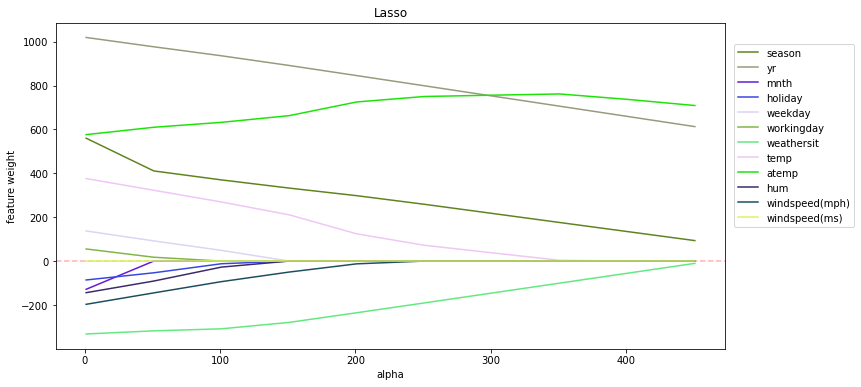

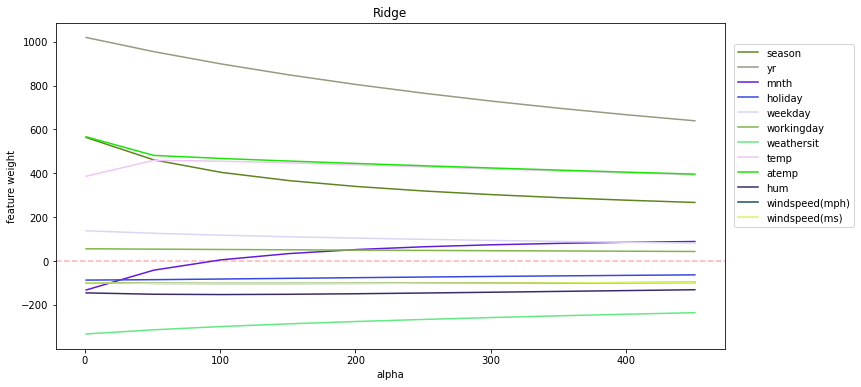

In [88]:
colors = [np.random.rand(3) for x in range(X.shape[1])]

plt.figure(figsize=(12, 6))
plt.axhline(y=0, c='r', linestyle='--', alpha=.3)
for i, (coef, feature) in enumerate(zip(coefs_lasso.T, df.columns)):
    plt.plot(alphas, coef, label=feature, color=colors[i])
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(12, 6))
plt.axhline(y=0, c='r', linestyle='--', alpha=.3)
for i, (coef, feature) in enumerate(zip(coefs_ridge.T, df.columns)):
    plt.plot(alphas, coef, label=feature, color=colors[i])
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
plt.show()

__Блок 3. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регрессор (Ridge или Lasso) агрессивнее уменьшает веса?
    * **ответ**: _Lasso_
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * **ответ**: _многие или даже все из них станут равны 0, так как Lasso с увеличением alpha обнуляет веса_
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha? А Ridge?
    * **ответ**: _Lasso - да, так как по графику видно, что веса windspeed (ms) при любом значении alpha равны 0, а Ridge - нет_
1. Какой из регрессоров подойдет для отбора неинформативных признаков?
    * **ответ**: _Lasso, так как он обнуляет неинформативные признаки_

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого в scikit-learn есть специальный класс __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) × k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [89]:
from sklearn.linear_model import LassoCV

In [192]:
alpha = np.arange(1, 100, 5)

##### Код 3.2 (1 балл)
Обучите регрессор LassoCV на всех параметрах регуляризации из alpha.

In [205]:
l_cv = LassoCV(alphas=alpha)
l_cv.fit(X, y)

LassoCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]))

Постройте график _усредненного_ по строкам MSE в зависимости от alpha. <br>

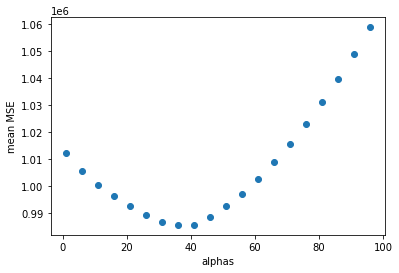

In [206]:
plt.scatter(l_cv.alphas_, l_cv.mse_path_.mean(axis=1))
plt.xlabel('alphas')
plt.ylabel('mean MSE')
plt.show()

Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов

In [207]:
best_alpha = l_cv.alpha_
best_alpha

36

In [212]:
for i, j in zip(df.columns, l_cv.coef_):
    print(i, j)

season 423.29084303507165
yr 989.3647596541274
mnth -0.0
holiday -64.26499759731684
weekday 104.82494838048366
workingday 29.11373699192689
weathersit -321.4575777176805
temp 338.0992158932663
atemp 603.6676626185714
hum -109.87822056063223
windspeed(mph) -160.29563707894903
windspeed(ms) -2.2743001185923243e-08


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

##### Код 3.3 (0.75 балла)

In [196]:
l_cv_new = LassoCV(cv=3)
l_cv_new.fit(X, y)

LassoCV(cv=3)

_Я приравниваю CV трем, так как в новой версии дефолтное CV равно пяти, а здесь, кажется, имелась в виду старая версия_

Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).

In [199]:
for n in l_cv_new.mse_path_.argmin(axis=0):
    print(l_cv_new.alphas_[n])

56.70495519666807
40.00422489506509
1.2216712257240543


На трех отдельных графиках визуализируйте столбцы .mse_path_

Text(0.5, 0, 'alphas')

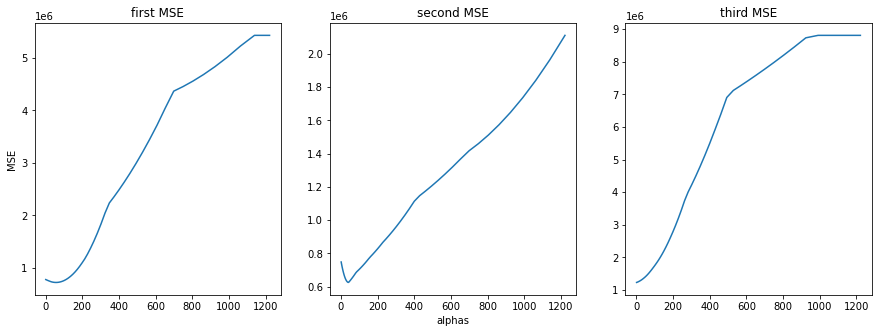

In [220]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
ax1.plot(l_cv_new.alphas_, l_cv_new.mse_path_.transpose()[0])
ax2.plot(l_cv_new.alphas_, l_cv_new.mse_path_.transpose()[1])
ax3.plot(l_cv_new.alphas_, l_cv_new.mse_path_.transpose()[2])
ax1.set_title('first MSE')
ax2.set_title('second MSE')
ax3.set_title('third MSE')
ax1.set_ylabel('MSE')
ax2.set_xlabel('alphas')

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 4. Ответьте на вопросы (каждый 0.25 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами, посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * **ответ**: _yr → atemp → season → temp_ <br>
    _если говорить про **(a)temp**, то тут видна возрастающая линейная зависмость: чем больше температура, тем больше велосипедов берут; также хорошо это ложится на **season**: весна и лето теплее → берут больше велосипедов; **yr** - наименее показательный признак, так как выборка состоит лишь из двух лет, поэтому сказать что-то трудно, но, возможно, это связано с возрастающей популярностью велосипеда как транспортного средства/увеличивающимся знанием о сервисе проката велосипеда/меньшим кол-вом данных про первый год (если они собирались не с самого начала 2011-го)_
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами, посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * **ответ**: _weathersit → windspeed(mph) → hum_ <br>
    _в контексте **weathersit** можно говорить про убывающую линейную зависимость: чем хуже погода, тем меньше велосипедов берут; с **windspeed(mph)** и **hum** все менее однозначно, так как зависимость, кажется, убывающая, но не совсем линейная: если сильный ветер/очень высокая влажность, велосипеды берут меньше (первое звучит логично, так как неудобно ездить при сильном ветре, а второе - возможно, связано с тем, что при высокой влажности велика вероятность осадков)_
1. Выберите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * **ответ**: _mnth, windspeed(ms)_ <br>
    _кооффициент при **windspeed(ms)** стремится к нулю, хотя зависимость такая же, как и у **windspeed(mph)**, так как мы специально "обнулили" этот признак при помощи Lasso (он линейно зависит от **windspeed(mph)** и влияет на спрос так же → мультиколлинеарность, которую мы хотим избежать); **mnth** влияет примерно так же, как и **season**, но зависимость нелинейная, поэтому он был исключен из модели_

In [190]:
l1_best = Lasso(alpha=best_alpha)
l1_best.fit(X, y)
for i, j in zip(df.columns, l1_best.coef_):
    print(i, j)

season 423.29084303507165
yr 989.3647596541274
mnth -0.0
holiday -64.26499759731684
weekday 104.82494838048366
workingday 29.11373699192689
weathersit -321.4575777176805
temp 338.0992158932663
atemp 603.6676626185714
hum -109.87822056063223
windspeed(mph) -160.29563707894903
windspeed(ms) -2.2743001185923243e-08


Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.